In [1]:
import os
import time
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torchvision import datasets, transforms

In [2]:
# Check if GPU is available
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:3


In [3]:
cifar_train = datasets.CIFAR10('./data', train=True, download=True ,transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('./data', train=False, download=True ,transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [02:11<00:00, 1291693.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Function to subsample CIFAR-10 dataset
def subsample_dataset(dataset, sample_size=1000):
    indices = np.random.choice(len(dataset), sample_size, replace=False)
    subset = Subset(dataset, indices)
    return subset

# Subsample the training and test datasets
sample_size = 1000
train_subset = subsample_dataset(cifar_train, sample_size=sample_size)
test_subset = subsample_dataset(cifar_test, sample_size=int(sample_size * 0.2))

# Load data into PyTorch DataLoader
train_loader = DataLoader(train_subset, batch_size=sample_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=int(sample_size * 0.2), shuffle=False)

# Fetch all data and labels for easier handling
X_train, y_train = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

print("Before Flattening")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Reshape the images to 2D tensors and move to device
X_train = X_train.view(X_train.size(0), -1).to(device)  # Flatten
X_test = X_test.view(X_test.size(0), -1).to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print("After Flattening")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Before Flattening
Training data shape: torch.Size([1000, 3, 32, 32])
Test data shape: torch.Size([200, 3, 32, 32])
After Flattening
Training data shape: torch.Size([1000, 3072])
Test data shape: torch.Size([200, 3072])


In [5]:
class ImageLinearClassifier:
    def __init__(self, input_size, n_classes, device=None):
        super().__init__()
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        print("Using device:", self.device)
        self.W = torch.nn.Parameter(torch.randn(n_classes, input_size, device=self.device) * 0.01)
        self.b = torch.nn.Parameter(torch.zeros(n_classes, device=self.device))

    def predict(self, X):
        # X: (batch_size, input_size)
        X = X.to(self.device)
        return X @ self.W.T + self.b  # (batch_size, n_classes)

    def compute_loss(self, X, y):
        X = X.to(self.device)
        y = y.to(self.device).long()
        logits = self.predict(X)
        return F.cross_entropy(logits, y)

    def gradient_descent(self, X, y, learning_rate=0.001):
        loss = self.compute_loss(X, y)
        loss.backward()
        with torch.no_grad():
            self.W -= learning_rate * self.W.grad
            self.b -= learning_rate * self.b.grad
        self.W.grad.zero_()
        self.b.grad.zero_()
        return loss.item()


In [6]:
def train(classifier, X_train, y_train, epochs, learning_rate):
    losses = []
    for i in range(epochs):
        loss = classifier.gradient_descent(X_train, y_train, learning_rate)
        losses.append(loss)
        print(f"Epoch {i+1}, Loss: {loss:.4f}")
    return losses

In [7]:
print(f"Training data: {len(cifar_train)}")
print(f"Test data: {len(cifar_test)}")

image, label = cifar_train[0]
# Now you can check the shape of the image
print(f"Image shape: {image.shape}")

Training data: 50000
Test data: 10000
Image shape: torch.Size([3, 32, 32])


In [8]:
# Example usage
n_classes = 10                                                                  # For CIFAR-10
image_size = 32 * 32 * 3                                                        # CIFAR-10 images are 32x32x3
classifier = ImageLinearClassifier(input_size=image_size, n_classes=n_classes)

# X_train is shape (image_size, batch_size) and y_train is (batch_size,)
losses = train(classifier, X_train, y_train, epochs=100, learning_rate=0.01)

Using device: cuda
Epoch 1, Loss: 2.3527
Epoch 2, Loss: 2.2998
Epoch 3, Loss: 2.2882
Epoch 4, Loss: 2.2798
Epoch 5, Loss: 2.2719
Epoch 6, Loss: 2.2643
Epoch 7, Loss: 2.2569
Epoch 8, Loss: 2.2497
Epoch 9, Loss: 2.2426
Epoch 10, Loss: 2.2358
Epoch 11, Loss: 2.2292
Epoch 12, Loss: 2.2227
Epoch 13, Loss: 2.2164
Epoch 14, Loss: 2.2103
Epoch 15, Loss: 2.2043
Epoch 16, Loss: 2.1985
Epoch 17, Loss: 2.1928
Epoch 18, Loss: 2.1872
Epoch 19, Loss: 2.1818
Epoch 20, Loss: 2.1765
Epoch 21, Loss: 2.1714
Epoch 22, Loss: 2.1663
Epoch 23, Loss: 2.1614
Epoch 24, Loss: 2.1566
Epoch 25, Loss: 2.1518
Epoch 26, Loss: 2.1472
Epoch 27, Loss: 2.1427
Epoch 28, Loss: 2.1383
Epoch 29, Loss: 2.1339
Epoch 30, Loss: 2.1297
Epoch 31, Loss: 2.1255
Epoch 32, Loss: 2.1214
Epoch 33, Loss: 2.1174
Epoch 34, Loss: 2.1135
Epoch 35, Loss: 2.1096
Epoch 36, Loss: 2.1058
Epoch 37, Loss: 2.1021
Epoch 38, Loss: 2.0985
Epoch 39, Loss: 2.0949
Epoch 40, Loss: 2.0913
Epoch 41, Loss: 2.0879
Epoch 42, Loss: 2.0845
Epoch 43, Loss: 2.0811
E

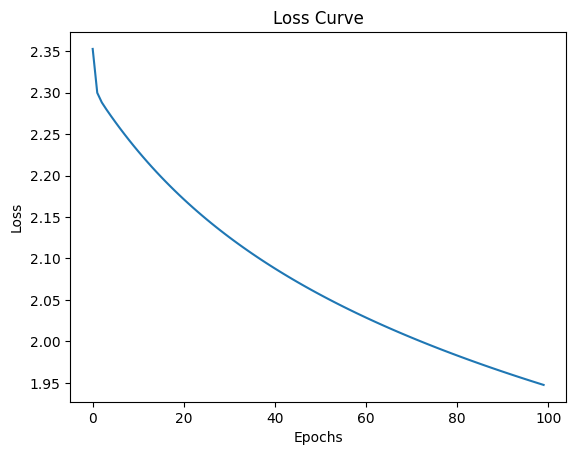

In [9]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()